# Hierarchical model with common $\sigma^2$

In [1]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
VARIABLE = 'MonthlyIncome'
ALPHA_LEVEL = 0.05

---

Read the data

In [3]:
Dat = pd.read_csv("../../../Data/Processed/DataProvince.csv")
ProvincesProvinceIdRegion = pd.read_csv("../../../Data/Enriched/ProvincesProvinceIdRegion.csv")

In [4]:
Dat = pd.merge(Dat, ProvincesProvinceIdRegion, on='ProvinceId')

In [5]:
Dat['Region'] = Dat['Region'].replace(
    {
        'NorthernThailand': 'Northern Thailand'
        , 'SouthernThailand': 'Southern Thailand'
        , 'WesternThailand': 'Western Thailand'
        , 'EasternThailand': 'Eastern Thailand'
        , 'NortheastThailand': 'Northeast Thailand'
        , 'CentralThailand': 'Central Thailand'
    }
)

Calculate the statistics per region

In [6]:
DatRegion = Dat[[VARIABLE + 'Mean', 'Region']].groupby('Region').agg(['count', 'mean', 'std']).reset_index()

DatRegion.columns = DatRegion.columns.droplevel()

DatRegion = DatRegion.rename(
    columns={
        '':'Region'
        , 'count': 'NumberObservations'
        , 'mean': VARIABLE + 'Mean'
        , 'std': VARIABLE + 'Std'}
    )

DatRegion = DatRegion.sort_values(VARIABLE + 'Mean').reset_index(drop=True)

J = len(DatRegion)
DatRegion['RegionOrder'] = range(J)

In [7]:
Dat = Dat[[VARIABLE + 'Mean', 'Region']]
Dat = pd.merge(Dat, DatRegion[['Region', 'RegionOrder']])

---

In [8]:
with pm.Model() as ModelCommonSigma:
    Sigma = pm.HalfFlat('Sigma')
    pm.Potential('p(Sigma)', -pm.math.log(Sigma))

    Tau    = pm.HalfFlat('Tau')
    Mu     = pm.Flat('Mu')
    Theta  = pm.Normal('Theta', mu=Mu, sigma=Tau, shape=J)

    Income = pm.Normal('Income', mu=Theta[Dat['RegionOrder']], sigma=Sigma, observed=Dat[VARIABLE + 'Mean'])

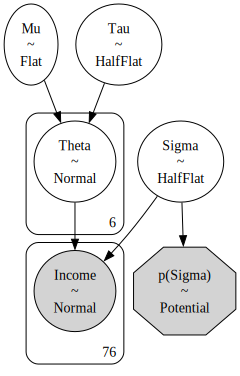

In [9]:
pm.model_to_graphviz(ModelCommonSigma)

---

### Posterior

In [10]:
with ModelCommonSigma:
    TraceCommonSigma = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Sigma, Tau, Mu, Theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


Text(0.5, 1.0, 'National average of monthly income, $\\mu$')

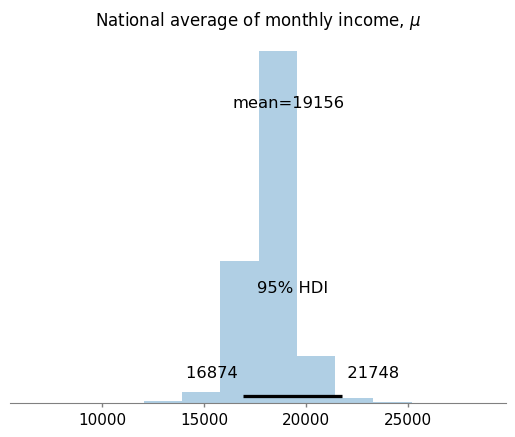

In [11]:
az.plot_posterior(
    TraceCommonSigma
    , var_names = 'Mu'
    , hdi_prob = 1-ALPHA_LEVEL
    , kind = 'hist'
    , textsize = 11
)

plt.title(r"National average of monthly income, $\mu$")

Text(0.5, 1.0, 'Between-regions deviation, $\\tau$')

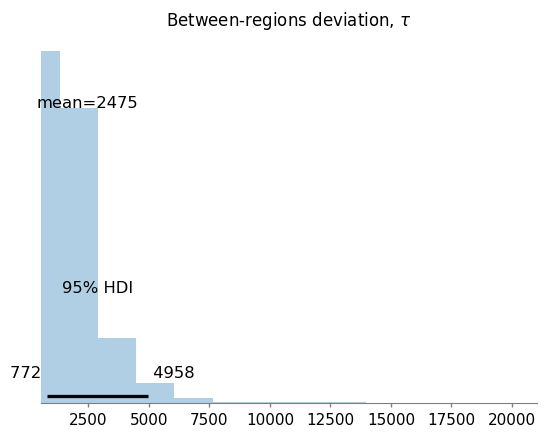

In [12]:
az.plot_posterior(
    TraceCommonSigma
    , var_names = 'Tau'
    , hdi_prob = 1-ALPHA_LEVEL
    , kind = 'hist'
    , textsize = 11
)

plt.title(r"Between-regions deviation, $\tau$")

In [13]:
PosteriorSigmaSummary = az.summary(TraceCommonSigma, var_names='Sigma', hdi_prob=1-ALPHA_LEVEL, kind='stats')
PosteriorThetaSummary = az.summary(TraceCommonSigma, var_names='Theta', hdi_prob=1-ALPHA_LEVEL, kind='stats')

In [14]:
DatRegion['HatTheta'] = PosteriorThetaSummary['mean'].values
DatRegion['LowTheta'] = PosteriorThetaSummary['hdi_' + str((ALPHA_LEVEL/2)*100)  + '%'].values
DatRegion['UppTheta'] = PosteriorThetaSummary['hdi_' + str((1-ALPHA_LEVEL/2)*100)  + '%'].values

DatRegion['HatSigma'] = [PosteriorSigmaSummary['mean'].values[0]] * J
DatRegion['LowSigma'] = [PosteriorSigmaSummary['hdi_' + str((ALPHA_LEVEL/2)*100)  + '%'].values[0]] * J
DatRegion['UppSigma'] = [PosteriorSigmaSummary['hdi_' + str((1-ALPHA_LEVEL/2)*100)  + '%'].values[0]] * J

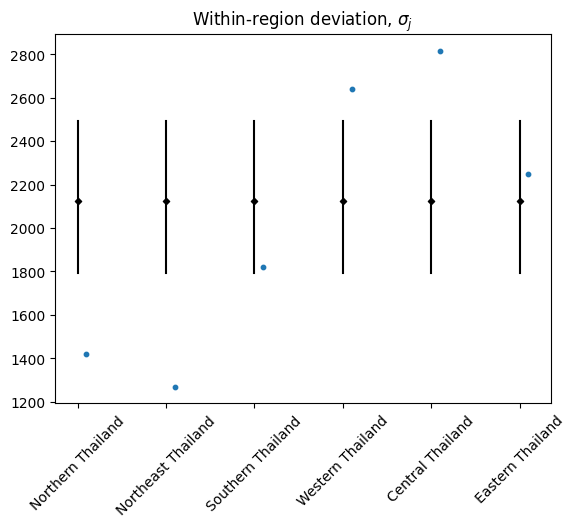

In [15]:
plt.scatter(range(J), DatRegion['HatSigma'], marker='D', color='k', s=10)
plt.scatter(np.arange(0.1, J+0.1, 1), DatRegion[VARIABLE + 'Std'], marker='o', color='C0', s=10)

for j in range(J):
    plt.plot(
        [j, j],
        [DatRegion['LowSigma'][j], DatRegion['UppSigma'][j]],
        color='k'
    )

plt.title(r"Within-region deviation, $\sigma_j$")
_ = plt.xticks(range(J), labels=DatRegion['Region'], rotation=45)

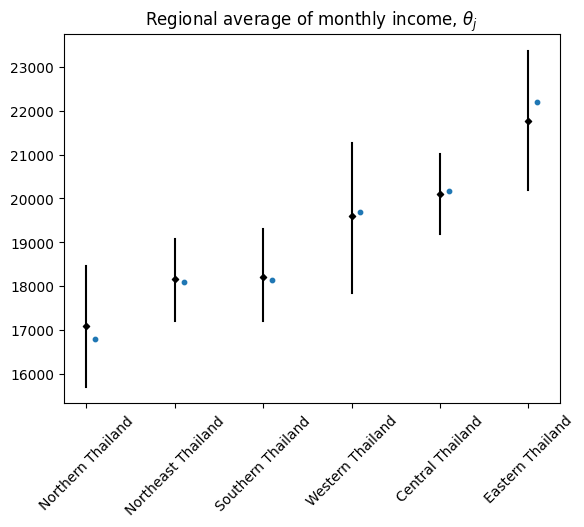

In [16]:
plt.scatter(range(J), DatRegion['HatTheta'], marker='D', color='k', s=10)
plt.scatter(np.arange(0.1, J+0.1, 1), DatRegion[VARIABLE + 'Mean'], marker='o', color='C0', s=10)

for j in range(J):
    plt.plot(
        [j, j],
        [DatRegion['LowTheta'][j], DatRegion['UppTheta'][j]],
        color='k'
    )

plt.title(r'Regional average of monthly income, $\theta_j$')
_ = plt.xticks(range(J), labels=DatRegion['Region'], rotation=45)

---

### Posterior Predictive

In [17]:
with ModelCommonSigma:
    TraceCommonSigma.extend(pm.sample_posterior_predictive(TraceCommonSigma))

Sampling: [Income]


In [18]:
PosteriorPredictiveSummary = az.summary(TraceCommonSigma, group='posterior_predictive', hdi_prob=1-ALPHA_LEVEL, kind='stats')

In [19]:
Dat['HatY'] = PosteriorPredictiveSummary['mean'].values
Dat['LowY'] = PosteriorPredictiveSummary['hdi_' + str((ALPHA_LEVEL/2)*100)  + '%'].values
Dat['UppY'] = PosteriorPredictiveSummary['hdi_' + str((1-ALPHA_LEVEL/2)*100)  + '%'].values

In [20]:
DatRegion = pd.merge(
    DatRegion
    , Dat.iloc[Dat['Region'].drop_duplicates().index][['Region', 'HatY', 'LowY', 'UppY']]
)

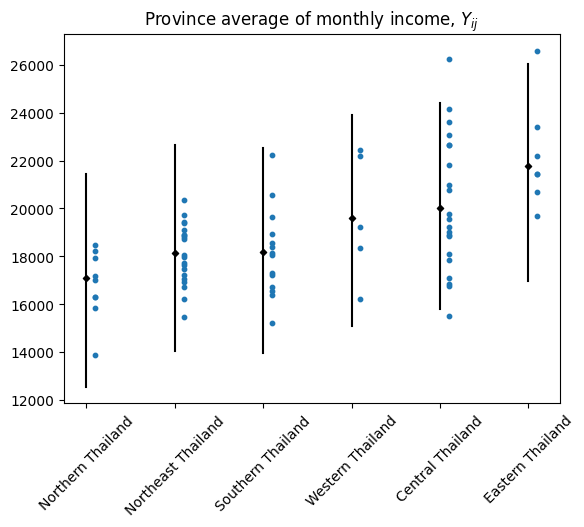

In [21]:
plt.scatter(range(J), DatRegion['HatY'], marker='D', color='k', s=10)

for j in range(J):
    plt.plot(
        [j, j],
        [DatRegion['LowY'][j], DatRegion['UppY'][j]],
        color='k'
    )

    
    plt.scatter(
        [j+0.1]*DatRegion.loc[DatRegion['Region'] == DatRegion['Region'][j], 'NumberObservations'][j]
        , Dat[Dat['Region'] == DatRegion['Region'][j]][VARIABLE + 'Mean']
        , marker='o'
        , color='C0'
        , s=10
        )

plt.title(r'Province average of monthly income, $Y_{ij}$')
_ = plt.xticks(range(J), labels=DatRegion['Region'], rotation=45)